# Data Directory Setup

In [1]:
import os
import shutil

In [2]:
os.listdir()

['.git',
 '.ipynb_checkpoints',
 '.vscode',
 'archive.zip',
 'binary_image_classification_model.pth',
 'COCO_Output',
 'FlowerDataset',
 'NucleiDataset',
 'pytorch_nn_imageClassification.ipynb',
 'yolo8.ipynb',
 'yolo_dataset']

In [3]:
def delete_all_directories_except(base_path, exceptions):
    for root, dirs, files in os.walk(base_path, topdown=False):
        for dir_name in dirs:
            dir_path = os.path.join(root, dir_name)
            if dir_name not in exceptions:
                print(f"Deleting directory: {dir_path}")
                shutil.rmtree(dir_path)
            else:
                print(f"Skipping directory: {dir_path}")

base_path = 'NucleiDataset/human_brain'

directories_to_keep = ["tissue images", "mask binary without border", "label masks modify"]

delete_all_directories_except(base_path, directories_to_keep)

Skipping directory: NucleiDataset/human_brain\label masks modify
Skipping directory: NucleiDataset/human_brain\mask binary without border
Skipping directory: NucleiDataset/human_brain\tissue images


# Converting Label Masks to COCO Json format

In [4]:
import cv2
import numpy as np
import json
from sklearn.model_selection import train_test_split

In [5]:
def get_image_mask_pairs(data_dir):
    image_paths = []
    mask_paths = []

    for root, _, files in os.walk(data_dir):
        if 'tissue images' in root:
            for file in files:
                if file.endswith(".png"):
                    image_paths.append(os.path.join(root, file))
                    mask_paths.append(os.path.join(root.replace('tissue images', 'label masks modify'), file.replace('.png', '.tif')))

    return image_paths, mask_paths

In [6]:
def mask_to_polygons(mask, epsilon=1.0):
    contours, _ = cv2.findContours(mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    polygons = []
    for contour in contours:
        if len(contour) > 2:
            poly = contour.reshape(-1).tolist()
            if len(poly) > 4:
                polygons.append(poly)

    return polygons

In [7]:
def process_data(image_paths, mask_paths, output_dir):
    annotations = []
    images = []
    image_id = 0
    ann_id = 0

    for img_path, mask_path in zip(image_paths, mask_paths):
        image_id +=1
        img = cv2.imread(img_path)
        mask = cv2.imread(mask_path, cv2.IMREAD_UNCHANGED)
        shutil.copy(img_path, os.path.join(output_dir, os.path.basename(img_path)))

        images.append({
            'id': image_id,
            'file_name': os.path.basename(img_path),
            'height': img.shape[0],
            'width': img.shape[1]
        })

        unique_values = np.unique(mask)
        for value in unique_values:
            if value == 0:
                continue

            object_mask = (mask == value).astype(np.uint8) * 255
            polygons = mask_to_polygons(object_mask)

            for poly in polygons:
                ann_id +=1
                annotations.append({
                    'id': ann_id,
                    'image_id': image_id,
                    'category_id': 1,
                    'segmentation_id': [poly],
                    'area': cv2.contourArea(np.array(poly).reshape(-1, 2)),
                    'bbox': list(cv2.boundingRect(np.array(poly).reshape(-1, 2))),
                    'iscrowd': 0
                })

    coco_output = {
        'images': images,
        'annotations': annotations,
        'categories': [{'id':1, 'name': 'Nuclei'}],
    }
    with open(os.path.join(output_dir, 'coco_annotations.json'), 'w') as f:
        json.dump(coco_output, f)

In [8]:
def main():
    data_dir = 'NucleiDataset/human_brain_2'
    output_dir = 'COCO_Output'
    train_dir = os.path.join(output_dir, 'train')
    val_dir = os.path.join(output_dir, 'val')

    os.makedirs(train_dir, exist_ok=True)
    os.makedirs(val_dir, exist_ok=True)

    image_paths, mask_paths = get_image_mask_pairs(data_dir)

    train_img_paths, val_img_paths, train_mask_paths, val_mask_paths = train_test_split(image_paths, mask_paths, test_size=.2, random_state=42)

    process_data(train_img_paths, train_mask_paths, train_dir)
    process_data(val_img_paths, val_mask_paths, val_dir)

if __name__ == '__main__':
    main()

# Coco Json to YOLO8

In [9]:
import json, os, shutil, yaml

In [10]:
def convert_to_yolo(input_images_path, input_json_path, output_images_path, output_labels_path):
    f = open(input_json_path)
    data = json.load(f)
    f.close()

    os.makedirs(output_images_path, exist_ok=True)
    os.makedirs(output_labels_path, exist_ok=True)

    # List to store filenames
    file_names = []
    for filename in os.listdir(input_images_path):
        if filename.endswith(".png"):
            source = os.path.join(input_images_path, filename)
            destination = os.path.join(output_images_path, filename)
            shutil.copy(source, destination)
            file_names.append(filename)

    def get_img_ann(image_id):
        return [ann for ann in data['annotations'] if ann['image_id'] == image_id]

    def get_img(filename):
        return next((img for img in data['images'] if img['file_name'] == filename), None)

    # Iterate through filenames and process each image
    for filename in file_names:
        img = get_img(filename)
        img_id = img['id']
        img_w = img['width']
        img_h = img['height']
        img_ann = get_img_ann(img_id)

        # Write normalized polygon data to a text file
        if img_ann:
            with open(os.path.join(output_labels_path, f"{os.path.splitext(filename)[0]}.txt"), "a") as file_object:
                for ann in img_ann:
                    current_category = ann['category_id'] - 1
                    polygon = ann['segmentation_id'][0]
                    normalized_polygon = [format(coord / img_w if i % 2 == 0 else coord / img_h, '.6f') for i, coord in enumerate(polygon)]
                    file_object.write(f"{current_category} " + " ".join(normalized_polygon) + "\n")

In [11]:
def create_yaml(input_json_path, output_yaml_path, train_path, val_path, test_path=None):
    with open(input_json_path) as f:
        data = json.load(f)
    
    # Extract the category names
    names = [category['name'] for category in data['categories']]
    
    # Number of classes
    nc = len(names)

    # Create a dictionary with the required content
    yaml_data = {
        'names': names,
        'nc': nc,
        'test': test_path if test_path else '',
        'train': train_path,
        'val': val_path
    }

    # Write the dictionary to a YAML file
    with open(output_yaml_path, 'w') as file:
        yaml.dump(yaml_data, file, default_flow_style=False)
        
if __name__ == "__main__":
    base_input_path = "COCO_Output/"
    base_output_path = "yolo_dataset/"

    # Processing validation dataset (if needed)
    convert_to_yolo(
        input_images_path=os.path.join(base_input_path, "val"),
        input_json_path=os.path.join(base_input_path, "val/coco_annotations.json"),
        output_images_path=os.path.join(base_output_path, "valid/images"),
        output_labels_path=os.path.join(base_output_path, "valid/labels")
    )

    # Processing training dataset 
    convert_to_yolo(
        input_images_path=os.path.join(base_input_path, "train"),
        input_json_path=os.path.join(base_input_path, "train/coco_annotations.json"),
        output_images_path=os.path.join(base_output_path, "train/images"),
        output_labels_path=os.path.join(base_output_path, "train/labels")
    )
    
    # Creating the YAML configuration file
    create_yaml(
        input_json_path=os.path.join(base_input_path, "train/coco_annotations.json"),
        output_yaml_path=os.path.join(base_output_path, "data.yaml"),
        train_path="train/images",
        val_path="valid/images",
        test_path='../test/images'  # or None if not applicable
    )

# Exploration

In [12]:
import os, random, json, cv2
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np

In [13]:
def display_images_with_coco_annotations(image_paths, annotations, display_type='both'):
    fig, axs = plt.subplots(2,2, figsize=(10,10))
    
    for ax, img_path in zip(axs.ravel(), image_paths):
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        ax.imshow(image)
        ax.axis('off')
        
        img_filename = os.path.basename(img_path)
        img_id = next(item for item in annotations['images'] if item['file_name'] == img_filename)['id']
        
        img_annotations = [ann for ann in annotations['annotations'] if ann['image_id'] == img_id]
        
        colors = [tuple(np.random.rand(3)) for _ in img_annotations]
        
        for ann, color, in zip(img_annotations, colors):
            if display_type in ['bbox', 'both']:
                bbox = ann['bbox']
                rect = patches.Rectangle((bbox[0], bbox[1]), bbox[2], bbox[3], linewidth=1, edgecolor=color)
                ax.add_patch(rect)
                
            if display_type in ['seg', 'both']:
                for seg in ann['segmentation_id']:
                    poly = [(seg[i], seg[i+1]) for i in range(0, len(seg), 2)]
                    polygon = patches.Polygon(poly, closed=True, edgecolor=color, fill=False)
                    ax.add_patch(polygon)
    
    plt.tight_layout()
    plt.show()

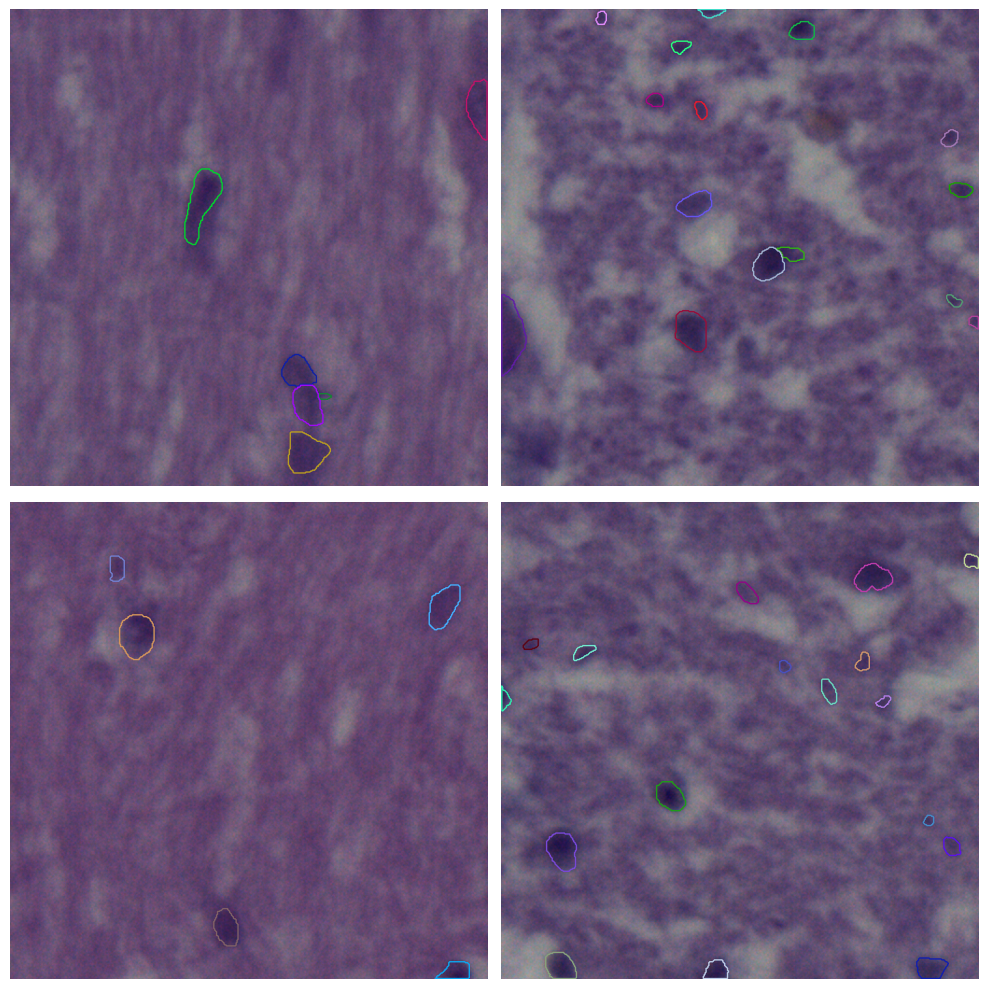

In [14]:
with open('COCO_Output/train/coco_annotations.json', 'r') as f:
    annotations = json.load(f)

image_dir = 'COCO_Output/train/'
all_image_files = [os.path.join(image_dir, img['file_name']) for img in annotations['images']]
random_image_files = random.sample(all_image_files, 4)

display_type = 'seg'

display_images_with_coco_annotations(random_image_files, annotations, display_type)

# Exploration - Label filled